In [1]:
 %load_ext autoreload

In [2]:
from opxrd.wrapper import OpXRD

# ------------------------------------------------------------

smoltest_dirpath = '/home/daniel/aimat/data/opXRD/test_smol'
bigtest_dirpath = '/home/daniel/aimat/data/opXRD/test'
test_databases = OpXRD.load_project_list(root_dirpath=smoltest_dirpath)

- Loading databases from /home/daniel/aimat/data/opXRD/test_smol
[2024-12-20 12:40:12]: Loading patterns from local dirpath /home/daniel/aimat/data/opXRD/test_smol/USC


100% (174 of 174) |######################| Elapsed Time: 0:00:00 Time:  0:00:000:00


[2024-12-20 12:40:12]: Finished loading pattern database located at /home/daniel/aimat/data/opXRD/test_smol/USC
[2024-12-20 12:40:12]: Successfully extracted 174 patterns from 174/174 xrd files
[2024-12-20 12:40:12]: Loading patterns from local dirpath /home/daniel/aimat/data/opXRD/test_smol/CNRS


100% (27 of 27) |########################| Elapsed Time: 0:00:00 Time:  0:00:000:00


[2024-12-20 12:40:12]: Finished loading pattern database located at /home/daniel/aimat/data/opXRD/test_smol/CNRS
[2024-12-20 12:40:12]: Successfully extracted 27 patterns from 27/27 xrd files


In [3]:
from opxrd.analysis import DatabaseAnalyser

%autoreload 2
analyser = DatabaseAnalyser(databases=test_databases, output_dirpath='/tmp/opxrd_analysis')

In [4]:
#analyser.plot_fourier_reference(b1=60, c1=1, b2=80, c2=1)

In [5]:
#analyser.plot_fourier()

---> Combined pattern plot for databaes ['a:USC', 'b:CNRS'] | No. patterns = 10

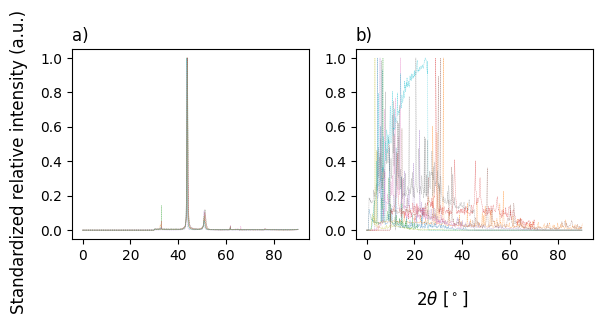

In [6]:
analyser.plot_in_single(limit_patterns=10)

---> Combined pattern plot for databaes ['a:USC', 'b:CNRS'] | No. patterns = 50

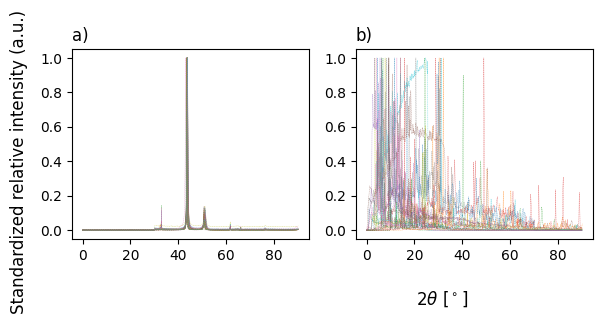

In [7]:
analyser.plot_in_single(limit_patterns=50)

---> Combined pattern plot for databaes ['a:USC', 'b:CNRS'] | No. patterns = 100

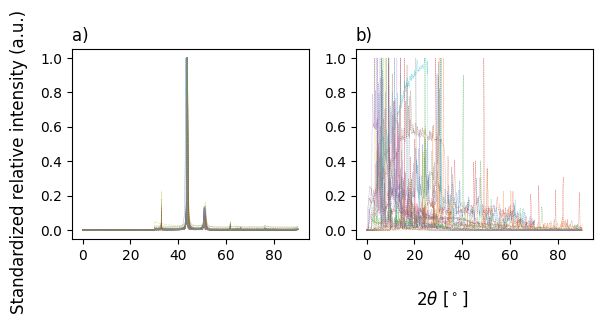

In [8]:
analyser.plot_in_single(limit_patterns=100)

---> Combined pattern plot for databaes ['a:USC', 'b:CNRS'] | No. patterns = 1000

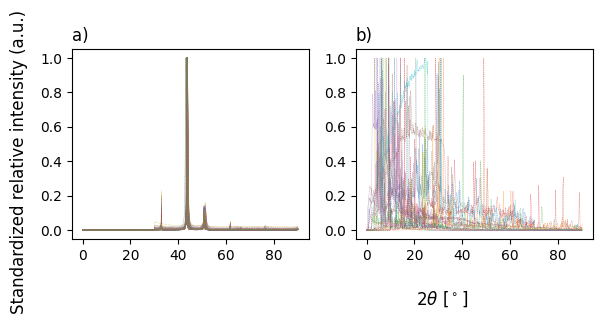

In [9]:
analyser.plot_in_single(limit_patterns=1000)

Cumulative explained variance ratio $v$ over components |  $v =  \frac{\sum_i \lambda_i}{\sum^n_{j=1} \lambda_j}$

[Debug]: Performing PCA for USC | No. patterns = 174
[Debug]: Performing PCA for CNRS | No. patterns = 27


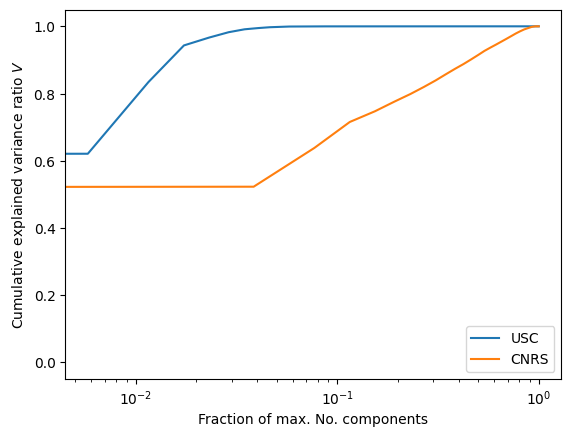

Cumulative explained variance ratio $v$ over components |  $v =  \frac{\sum_i \lambda_i}{\sum^n_{j=1} \lambda_j}$

[Debug]: Performing PCA for USC | No. patterns = 174
[Debug]: Performing PCA for CNRS | No. patterns = 27


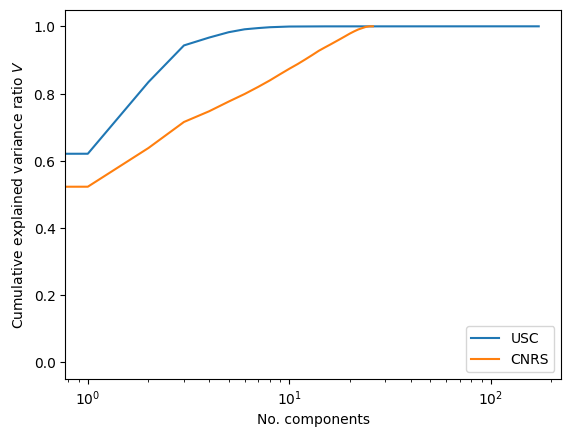

In [10]:
analyser.plot_effective_components()
analyser.plot_effective_components(use_fractions=False)

In [ ]:
analyser.plot_histogram()

---> Histogram of general information on opXRD

In [ ]:
analyser.show_label_fractions()
analyser.print_total_counts()